# Data loading

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

csv_path = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv(csv_path)

print("Dataset path:", csv_path)
print("Shape:", df.shape)

df.head()

Dataset path: data/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
df_clean = df.copy()

df_clean["TotalCharges"] = df_clean["TotalCharges"].replace(" ", np.nan)
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

print("Missing TotalCharges after conversion:", df_clean["TotalCharges"].isna().sum())
if df_clean["TotalCharges"].isna().sum() > 0:
    display(df_clean[df_clean["TotalCharges"].isna()].head())

print("\nValue counts of tenure==0 among TotalCharges NA:")
print((df_clean[df_clean["TotalCharges"].isna()]["tenure"] == 0).sum())

df_clean["TotalCharges_filled"] = df_clean["TotalCharges"].fillna(
    df_clean["MonthlyCharges"] * df_clean["tenure"]
)

Missing TotalCharges after conversion: 11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No



Value counts of tenure==0 among TotalCharges NA:
11


## Market Basket Analysis (Apriori & Association Rules)

This section prepares a transactional basket of services and runs Apriori to find frequent itemsets and association rules.
Visualizations: top frequent items (bar), co-occurrence heatmap, and a rules scatter (support vs confidence, sized by lift).

In [16]:
service_cols = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

# Ensure required columns exist
missing = [c for c in service_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns for Task 3: {missing}")

df_market = df[service_cols].copy()

def yes(x):  # helper to map Yes/No-like fields with 'No ... service' variants
    return x == "Yes"

df_basket = pd.DataFrame(index=df_market.index)
# Phone / Lines
df_basket["PhoneService"] = df_market["PhoneService"].apply(lambda v: v == "Yes")
df_basket["MultipleLines"] = df_market["MultipleLines"].apply(lambda v: v == "Yes")
# Internet types
df_basket["Internet_DSL"] = df_market["InternetService"].apply(lambda v: v == "DSL")
df_basket["Internet_Fiber"] = df_market["InternetService"].apply(lambda v: v == "Fiber optic")
# Internet-dependent add-ons (treat any 'No internet service' as False)
df_basket["OnlineSecurity"] = df_market["OnlineSecurity"].apply(lambda v: v == "Yes")
df_basket["OnlineBackup"] = df_market["OnlineBackup"].apply(lambda v: v == "Yes")
df_basket["DeviceProtection"] = df_market["DeviceProtection"].apply(lambda v: v == "Yes")
df_basket["TechSupport"] = df_market["TechSupport"].apply(lambda v: v == "Yes")
df_basket["StreamingTV"] = df_market["StreamingTV"].apply(lambda v: v == "Yes")
df_basket["StreamingMovies"] = df_market["StreamingMovies"].apply(lambda v: v == "Yes")
# Force booleans for any stray values
df_basket = df_basket.fillna(False).astype(bool)

print("\nBasket data prepared:")
print(df_basket.head())




Basket data prepared:
   PhoneService  MultipleLines  Internet_DSL  Internet_Fiber  OnlineSecurity  \
0         False          False          True           False           False   
1          True          False          True           False            True   
2          True          False          True           False            True   
3         False          False          True           False            True   
4          True          False         False            True           False   

   OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
0          True             False        False        False            False  
1         False              True        False        False            False  
2          True             False        False        False            False  
3         False              True         True        False            False  
4         False             False        False        False            False  


## Apriori

In [17]:
# --- Apriori ---
print("\nRunning Apriori to find frequent itemsets (min_support=0.2)...")
frequent_itemsets = apriori(df_basket, min_support=0.2, use_colnames=True)
print("Frequent Itemsets found (top by support):")
print(frequent_itemsets.sort_values(by="support", ascending=False).head())

# --- Association Rules ---
print("\nGenerating association rules (min_confidence=0.7)...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)


Running Apriori to find frequent itemsets (min_support=0.2)...
Frequent Itemsets found (top by support):
     support                        itemsets
0   0.903166                  (PhoneService)
3   0.439585                (Internet_Fiber)
12  0.439585  (PhoneService, Internet_Fiber)
1   0.421837                 (MultipleLines)
10  0.421837   (PhoneService, MultipleLines)

Generating association rules (min_confidence=0.7)...


## Visualization


--- Top Association Rules (Sorted by Lift) ---


,antecedents,consequents,support,confidence,lift
0,"(PhoneService, StreamingMovies)",(StreamingTV),0.247054,0.714873,1.859936
1,"(PhoneService, StreamingTV)",(StreamingMovies),0.247054,0.718415,1.852047
2,(StreamingTV),(StreamingMovies),0.275451,0.716661,1.847526
3,(StreamingMovies),(StreamingTV),0.275451,0.710102,1.847526
4,"(PhoneService, StreamingTV)",(Internet_Fiber),0.248474,0.722543,1.643693
5,"(PhoneService, StreamingMovies)",(Internet_Fiber),0.248616,0.719392,1.636524
6,"(StreamingMovies, Internet_Fiber)",(PhoneService),0.248616,1.000000,1.107216
7,"(Internet_Fiber, StreamingTV)",(PhoneService),0.248474,1.000000,1.107216
8,"(StreamingMovies, MultipleLines)",(PhoneService),0.225898,1.000000,1.107216
9,"(MultipleLines, StreamingTV)",(PhoneService),0.223910,1.000000,1.107216


Association rules exported to market_basket_exports/association_rules.csv


/tmp/ipykernel_112237/1404301561.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.head(top_n).values, y=item_counts.head(top_n).index, palette='viridis')


Top frequent items bar saved to market_basket_exports/top_frequent_items.png


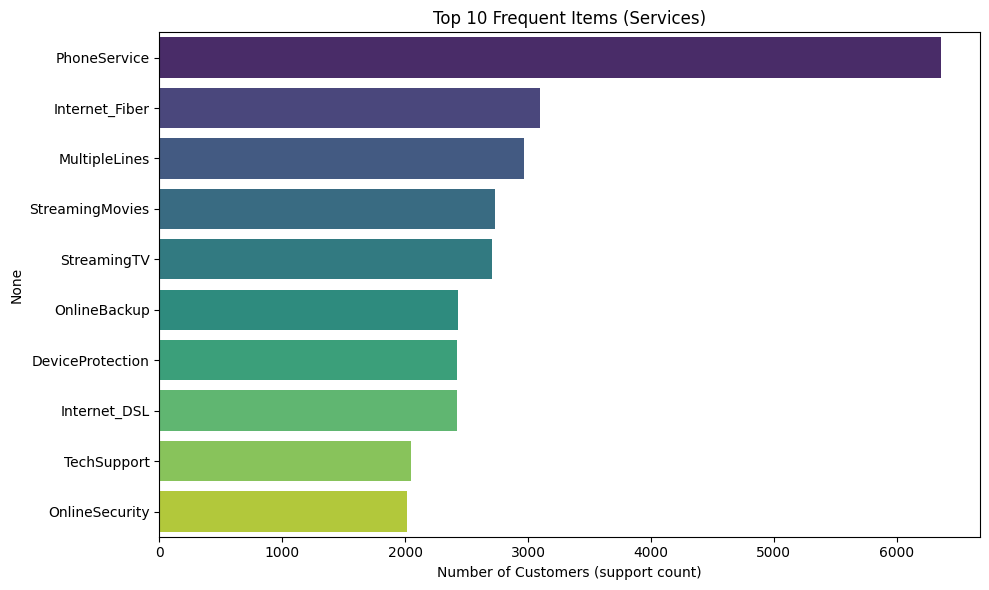

Co-occurrence heatmap saved to market_basket_exports/services_cooccurrence_heatmap.png


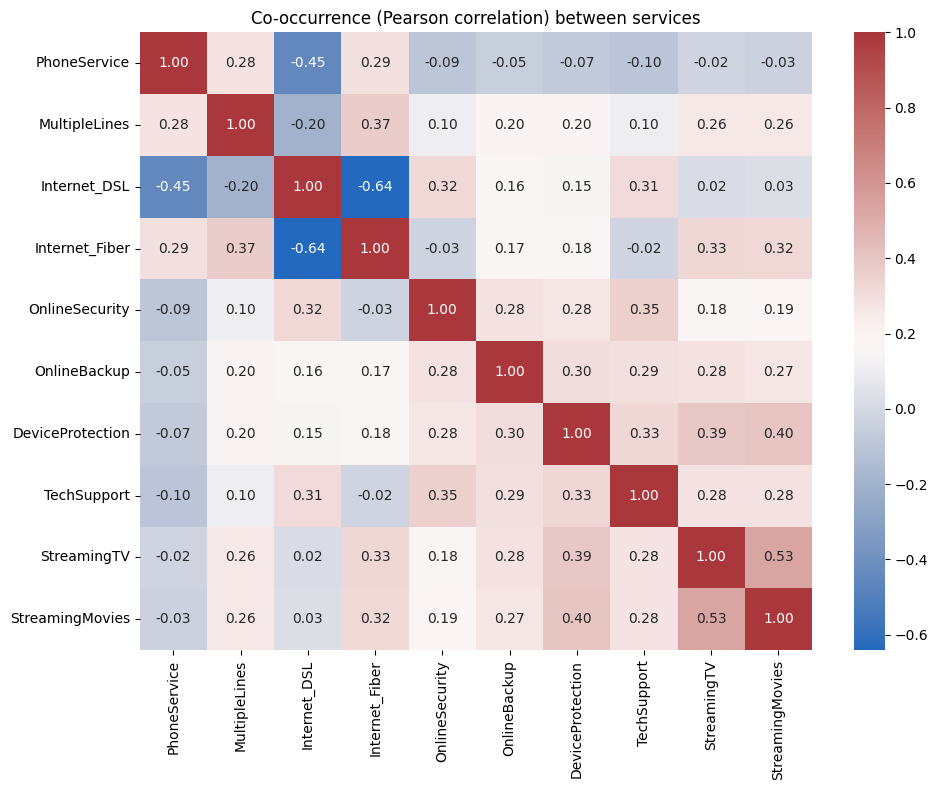

Rules scatter saved to market_basket_exports/rules_support_confidence.png


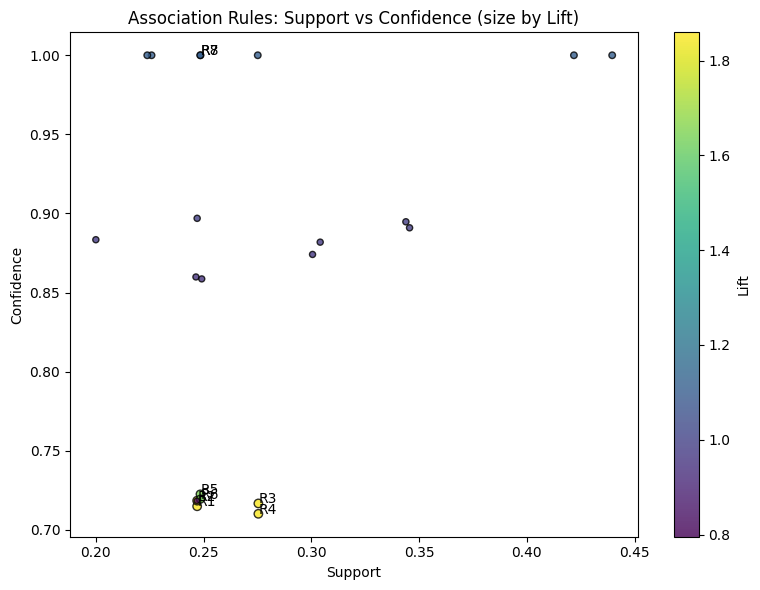



--- Analysis Complete ---


In [18]:
# create export dir for this notebook
export_dir = 'market_basket_exports'
os.makedirs(export_dir, exist_ok=True)

if rules.empty:
    print("\nNo rules found with min_confidence=0.7.")
    print("Try lowering 'min_threshold' for confidence or 'min_support'.")
else:
    rules = rules.sort_values(by="lift", ascending=False).reset_index(drop=True)
    print("\n--- Top Association Rules (Sorted by Lift) ---")
    display_cols = ["antecedents", "consequents", "support", "confidence", "lift"]
    display(rules[display_cols].head(10))
    # export rules to CSV (convert frozensets to strings)
    rules_out = rules.copy()
    rules_out['antecedents'] = rules_out['antecedents'].apply(lambda s: ','.join(sorted(list(s))))
    rules_out['consequents'] = rules_out['consequents'].apply(lambda s: ','.join(sorted(list(s))))
    rules_csv = os.path.join(export_dir, 'association_rules.csv')
    rules_out.to_csv(rules_csv, index=False)
    print(f'Association rules exported to {rules_csv}')

    # --- Visualization 1: Top frequent items (bar) ---
    item_counts = df_basket.sum().sort_values(ascending=False)
    top_n = 10
    plt.figure(figsize=(10, 6))
    sns.barplot(x=item_counts.head(top_n).values, y=item_counts.head(top_n).index, palette='viridis')
    plt.xlabel('Number of Customers (support count)')
    plt.title(f'Top {top_n} Frequent Items (Services)')
    bar_path = os.path.join(export_dir, 'top_frequent_items.png')
    plt.tight_layout()
    plt.savefig(bar_path)
    print(f'Top frequent items bar saved to {bar_path}')
    plt.show()

    # --- Visualization 2: Co-occurrence heatmap (correlation) ---
    plt.figure(figsize=(10, 8))
    corr = df_basket.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag')
    plt.title('Co-occurrence (Pearson correlation) between services')
    heatmap_path = os.path.join(export_dir, 'services_cooccurrence_heatmap.png')
    plt.tight_layout()
    plt.savefig(heatmap_path)
    print(f'Co-occurrence heatmap saved to {heatmap_path}')
    plt.show()

    # --- Visualization 3: Rules scatter (support vs confidence), sized by lift ---
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(rules['support'], rules['confidence'], s=(rules['lift']*20), c=rules['lift'], cmap='viridis', alpha=0.8, edgecolors='k')
    plt.colorbar(sc, label='Lift')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title('Association Rules: Support vs Confidence (size by Lift)')
    # annotate top rules by lift
    for i, row in rules.head(8).iterrows():
        plt.annotate(f'R{i+1}', (row['support'], row['confidence']))
    rules_scatter_path = os.path.join(export_dir, 'rules_support_confidence.png')
    plt.tight_layout()
    plt.savefig(rules_scatter_path)
    print(f'Rules scatter saved to {rules_scatter_path}')
    plt.show()

print("\n\n--- Analysis Complete ---")